# ASAP: A Dynamic & Proactive Approach for **A**ndroid **S**ecurity **A**nalysis and **P**rivacy

**Authors:** João Felisberto (joaofelisberto@ua.pt), Catarina Silva (c.alexandracorreia@ua.pt)

**Date:** 17/04/2024




In [1]:
%matplotlib inline
import gzip
import requests
import textwrap
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, matthews_corrcoef, f1_score
from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
import tensorflow.keras.backend as K
from tqdm.keras import TqdmCallback


#plt.style.use('seaborn-v0_8-paper')
plt.style.use('tableau-colorblind10')
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['lines.linewidth'] = 2

# Color Blind adjusted colors and markers
colormap=['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']
markers=['o', '*', '.', 'x', '+', 's', 'd', 'h', 'v']
lines=['-', ':', '--', '-.']

2024-04-09 22:26:18.136816: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load and clean the datasets

In [2]:
f=gzip.open('dataset/exodus.csv.gz','rb')
file_content=f.read()
df_exodus = pl.read_csv(file_content)

df_exodus = df_exodus.rename({col: col.lower() for col in df_exodus.columns})
df_exodus = df_exodus.rename({'class': 'label'})
if 'package' in df_exodus.columns: # deal with null values
    df_exodus = df_exodus.filter(pl.col('package').is_not_null())

df_exodus_clean = df_exodus.drop(['name', 'id', 'package', 'app', 'price', 'related apps', 'category', 'dangerous permissions count'])

f=gzip.open('dataset/android_permission_dataset.csv.gz','rb')
file_content=f.read()
df_apd = pl.read_csv(file_content)

df_apd = df_apd.rename({col: col.lower() for col in df_apd.columns})
df_apd = df_apd.rename({'class': 'label'})
if 'package' in df_apd.columns: # deal with null values
    df_apd = df_apd.filter(pl.col('package').is_not_null())

df_apd_clean = df_apd.drop(['name', 'id', 'package', 'app', 'price', 'related apps', 'category', 'dangerous permissions count'])

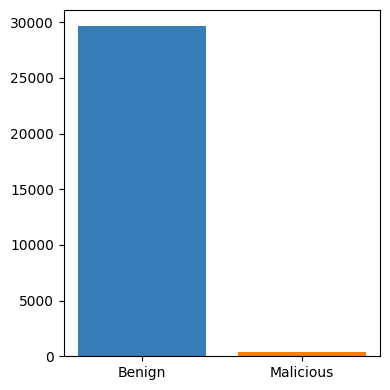

Percentage of Malicious Applications: 1.3%


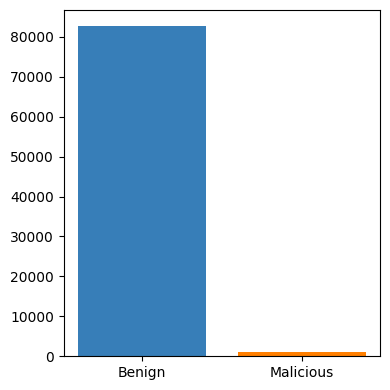

Percentage of Malicious Applications: 1.3%


In [3]:
dfs_clean = [df_exodus_clean, df_apd_clean]

for df_clean, name in zip(dfs_clean, ['exodus', 'apd']):
    df_malicious = df_clean.filter(pl.col('label') == 1)
    df_benign    = df_clean.filter(pl.col('label') == 0)
    
    plt.bar(['Benign'], [df_benign.shape[0]], color = colormap[0], width = 0.8)
    plt.bar(['Malicious'], [df_malicious.shape[0]], color = colormap[1], width = 0.8)
    
    plt.savefig(f'out/dataset_class_ratio_{name}.png', bbox_inches='tight', transparent=True)
    plt.savefig(f'out/dataset_class_ratio_{name}.pdf', bbox_inches='tight', transparent=True)
    plt.show()
    print(f'Percentage of Malicious Applications: {len(df_malicious)/(len(df_malicious) + len(df_benign)):.1%}')

In [4]:
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width, break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

## Logistic Regression (Reference Model)

MCC: 0.7369751620185037 F1-Score 0.8296795952782462


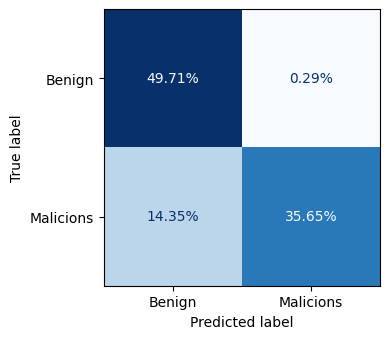

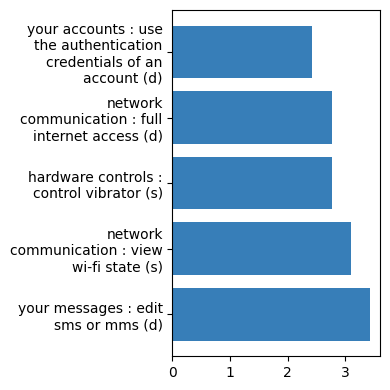

MCC: 0.6052131906142104 F1-Score 0.6980645161290323


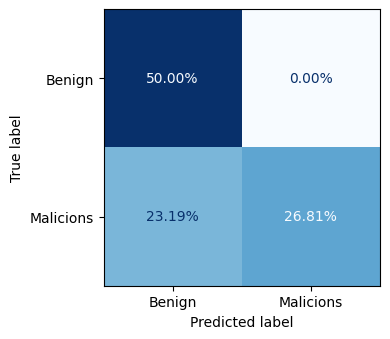

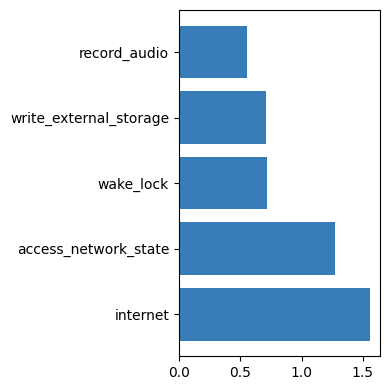

In [5]:
for df_clean, name in zip(dfs_clean, ['exodus', 'apd']):
    undersample = RandomUnderSampler(sampling_strategy='majority')
    Y = df_clean['label']
    X = df_clean.drop(['label'])

    X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), Y.to_numpy(), test_size=0.9, random_state=42, stratify=Y)
    X_test, y_test = undersample.fit_resample(X_test, y_test)

    clf = LogisticRegression(random_state=42, solver='saga', max_iter=300, penalty=None, tol=1E-3)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    mcc = matthews_corrcoef(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f'MCC: {mcc} F1-Score {f1}')

    cf_matrix = confusion_matrix(y_test, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix/np.sum(cf_matrix),
    display_labels = ['Benign', 'Malicions'])
    cm_display.plot(values_format='.2%', colorbar=False, cmap='Blues')
    plt.savefig(f'out/cm_lr_{name}.png', bbox_inches='tight', transparent=True)
    plt.savefig(f'out/cm_lr_{name}.pdf', bbox_inches='tight', transparent=True)
    plt.show() 

    weights = clf.coef_[0]
    abs_weights = np.abs(weights)
    features = np.array(X.columns)
    sorted_index = np.argsort(abs_weights)[::-1]
    top_high_k = sorted_index[:5]

    labels = features[top_high_k]
    labels = [textwrap.fill(l, width=20, break_long_words=False) for l in labels]
   
    plt.barh(y=labels, width=abs_weights[top_high_k], color = colormap[0])
    plt.savefig(f'out/feature_ranking_lr_{name}.png', bbox_inches='tight', transparent=True)
    plt.savefig(f'out/feature_ranking_lr_{name}.pdf', bbox_inches='tight', transparent=True)
    plt.show()

## Random Forest (Reference Model)

MCC: 0.5740032829053568 F1-Score 0.6627906976744186


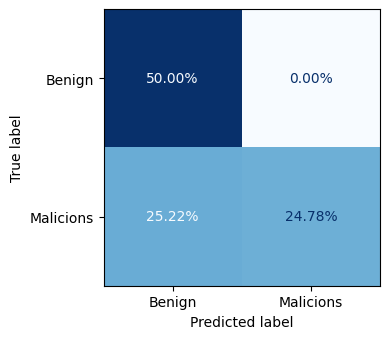

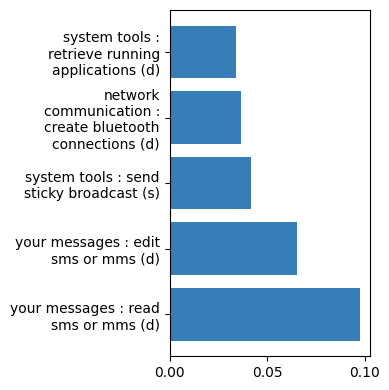

MCC: 0.7435176285956795 F1-Score 0.8323699421965318


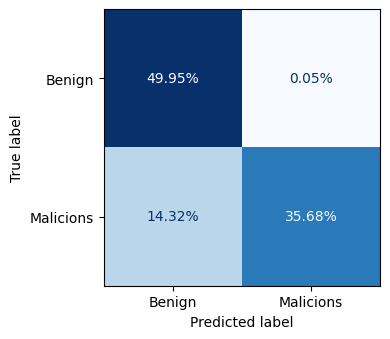

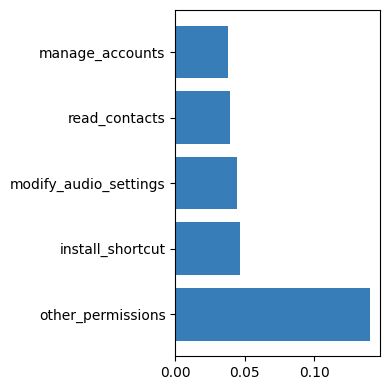

In [6]:
for df_clean, name in zip(dfs_clean, ['exodus', 'apd']):
    undersample = RandomUnderSampler(sampling_strategy='majority')
    Y = df_clean['label']
    X = df_clean.drop(['label'])

    X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), Y.to_numpy(), test_size=0.9, random_state=42, stratify=Y)
    X_test, y_test = undersample.fit_resample(X_test, y_test)

    clf = RandomForestClassifier(n_estimators=32, n_jobs=-1, random_state=42, max_depth = 16)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    mcc = matthews_corrcoef(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f'MCC: {mcc} F1-Score {f1}')

    cf_matrix = confusion_matrix(y_test, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix/np.sum(cf_matrix),
    display_labels = ['Benign', 'Malicions'])
    cm_display.plot(values_format='.2%', colorbar=False, cmap='Blues')
    plt.savefig(f'out/cm_rf_{name}.png', bbox_inches='tight', transparent=True)
    plt.savefig(f'out/cm_rf_{name}.pdf', bbox_inches='tight', transparent=True)
    plt.show() 

    # Feature importance
    weights = clf.feature_importances_
    abs_weights = np.abs(weights)
    features = np.array(X.columns)
    sorted_index = np.argsort(abs_weights)[::-1]
    top_high_k = sorted_index[:5]
    #top_low_k = sorted_index[-5:]

    labels = features[top_high_k]
    labels = [textwrap.fill(l, width=20, break_long_words=False) for l in labels]
   
    plt.barh(y=labels, width=abs_weights[top_high_k], color = colormap[0])
    plt.savefig(f'out/feature_ranking_rf_{name}.png', bbox_inches='tight', transparent=True)
    plt.savefig(f'out/feature_ranking_rf_{name}.pdf', bbox_inches='tight', transparent=True)
    plt.show()

## AutoEncoder Model (Proposed Solution)


In [7]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def isodata(array: np.ndarray) -> float:
    """
    Returns optimal threshold for dividing the sequence of values.

    Args:
        array (np.ndarray): numpy array with the values
    
    Returns:
        float: optimal threshold for dividing the sequence of values
    """
    median = np.median(array)
    previous_median = 0.0 
    
    while median != previous_median:
        median_left = np.median(array[array <= median])
        median_right = np.median(array[array > median])

        previous_median = median
        median = (median_left+median_right) / 2.0

    return median

def mad_score(points):
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    return 0.6745 * ad / mad

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 203)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        26,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 203)            │        26,187 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,203 (239.07 KB)

 Trainable params: 61,203 (239.07 KB)

 Non-trainable params: 0 (0.00 B)

0epoch [00:00, ?epoch/s]

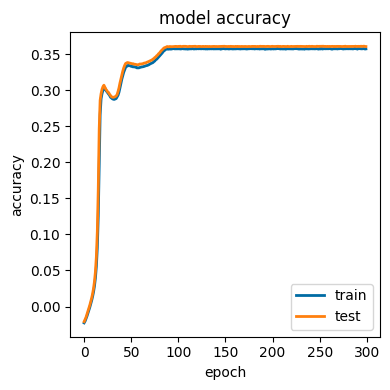

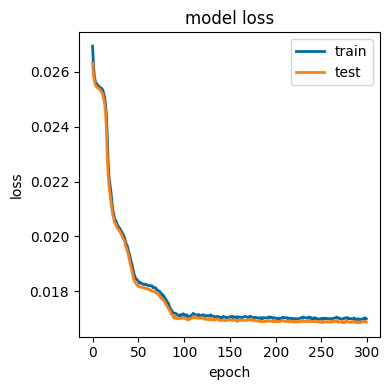

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
0.5% anomaly
ISO-Data Thr: 0.059608313095182906


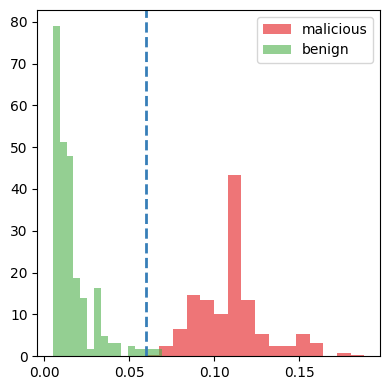

MCC: 0.9837074072974891 F1-Score 0.991869918699187


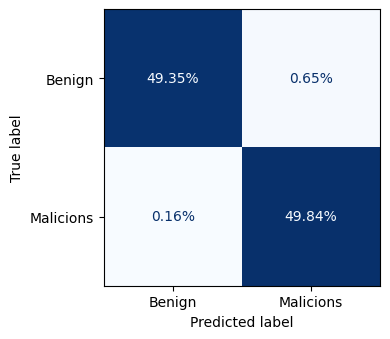

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 121)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 121)            │        15,609 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,129 (156.75 KB)

 Trainable params: 40,129 (156.75 KB)

 Non-trainable params: 0 (0.00 B)

0epoch [00:00, ?epoch/s]

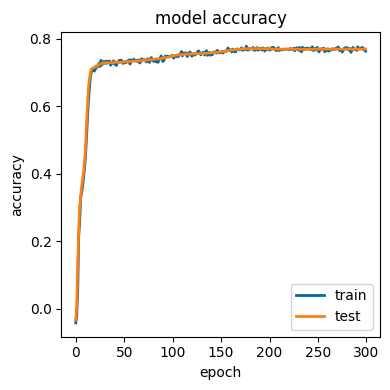

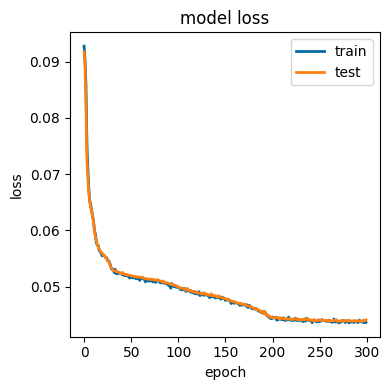

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
0.5% anomaly
ISO-Data Thr: 0.10170380427029879


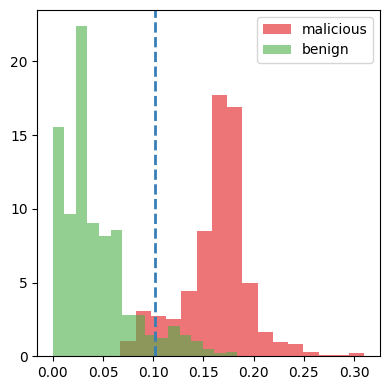

MCC: 0.7880893552903152 F1-Score 0.8888888888888888


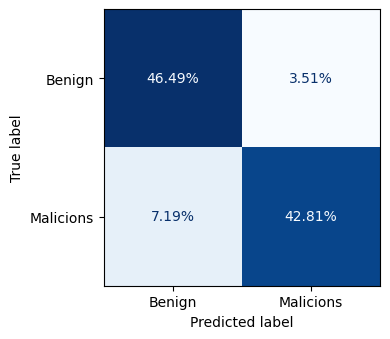

In [8]:
for df_clean, name in zip(dfs_clean, ['exodus', 'apd']):
    undersample = RandomUnderSampler(sampling_strategy='majority')
    Y = df_clean['label']
    X = df_clean.drop(['label'])

    X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), Y.to_numpy(), test_size=0.8, random_state=42, stratify=Y)
    
    # Need to remove malicions samples
    X_train = X_train[y_train == 0]
    X_validation = X_test[y_test == 0]

    # undersample the Test part
    X_test, y_test = undersample.fit_resample(X_test, y_test)
    
    # data dimensions // hyperparameters 
    input_dim = X_train.shape[-1]
    latent_dim = 8

    inputlayer = tf.keras.layers.Input(shape = (input_dim, ))
    encoder_00 = tf.keras.layers.Dense(128, kernel_initializer='glorot_uniform', activation='silu')(inputlayer)
    encoder_01 = tf.keras.layers.Dense(32, kernel_initializer='glorot_uniform', activation='silu')(encoder_00)

    latent = tf.keras.layers.Dense(latent_dim, kernel_initializer='glorot_uniform', activation='silu')(encoder_01)

    decoder_00 = tf.keras.layers.Dense(32, kernel_initializer='glorot_uniform', activation='silu')(latent)
    decoder_01 = tf.keras.layers.Dense(128, kernel_initializer='glorot_uniform', activation='silu')(decoder_00)
    outputlayer = tf.keras.layers.Dense(input_dim, kernel_initializer='glorot_uniform', activation='linear')(decoder_01)

    autoencoder = tf.keras.Model(inputs = inputlayer, outputs = outputlayer)
    autoencoder.compile(optimizer='adam', loss='mae', metrics=[coeff_determination])
    autoencoder.summary()

    EPOCHS = 300
    BATCH_SIZE = 1024
    history = autoencoder.fit(X_train, X_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
    validation_data=(X_validation, X_validation), verbose=0, callbacks=[TqdmCallback(verbose=0)])

    # summarize history for accuracy
    plt.plot(history.history['coeff_determination'])
    plt.plot(history.history['val_coeff_determination'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

    reconstructions = autoencoder.predict(X_test)
    mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)
    mae = np.mean(np.abs(X_test - reconstructions), axis=1)

    malicious = mae[y_test==1]
    benign    = mae[y_test==0]

    print(f"{len(malicious)/(len(benign)+len(malicious)):.2}% anomaly")

    thr = isodata(mae)
    print(f'ISO-Data Thr: {thr}')
    y_pred = mse > thr

    #fig, ax = plt.subplots(figsize=(6,6))
    ax = plt.gca()
    ax.hist(malicious, bins=16, density=True, label="malicious", alpha=.6, color=colormap[7])
    ax.hist(benign, bins=16, density=True, label="benign", alpha=.6, color=colormap[2])
    plt.axvline(x = thr, color = colormap[0], linestyle='--')
    #plt.title("(Normalized) Distribution of the Reconstruction Error")
    plt.legend()
    plt.savefig(f'out/error_distribution{name}.png', bbox_inches='tight', transparent=True)
    plt.savefig(f'out/error_distribution{name}.pdf', bbox_inches='tight', transparent=True)
    plt.show()

    mcc = matthews_corrcoef(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f'MCC: {mcc} F1-Score {f1}')

    cf_matrix = confusion_matrix(y_test, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix/np.sum(cf_matrix),
    display_labels = ['Benign', 'Malicions'])
    cm_display.plot(values_format='.2%', colorbar=False, cmap='Blues')
    plt.savefig(f'out/cm_ae_{name}.png', bbox_inches='tight', transparent=True)
    plt.savefig(f'out/cm_ae_{name}.pdf', bbox_inches='tight', transparent=True)
    plt.show()